In [1]:
import ray
from ray import tune
from ray.tune import ResultGrid
import matplotlib.pyplot as plt
ray.init()

2023-04-02 17:55:14,222	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


In [235]:

ray_results_dir = "/Users/FrankVerhoef/Programming/PEX/checkpoints/ray_results/"
experiments = [
    {
        'exp_file': "train_with_args_2023-03-29_23-24-42", 
        'comment': "Tune PrefixBert with speaker prefixes <self>, <other>",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/prefix_aggr', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_10-12-15", 
        'comment': "Tune PrefixBert without speaker prefixes",
        'grouplist': ['config/freeze', 'config/prefix_size', 'config/batch_size', 'config/learning_rate']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-21-13", 
        'comment': "Tune Bart, without speaker prefixes",
        'grouplist': ['config/learning_rate', 'config/batch_size']
    }, {
        'exp_file': "train_with_args_2023-03-30_23-55-16", 
        'comment': "Tune PrefixBart"
    },
]


In [236]:
exp=experiments[2]
exp_name = exp['exp_file']
grouplist = exp['grouplist']

In [237]:
restored_tuner = tune.Tuner.restore(ray_results_dir + exp_name)

/Users/FrankVerhoef/opt/miniconda3/envs/pex/lib/python3.9/site-packages/ray/tune/tuner.py:230: UserWarning: Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
  warnings.warn(warning_message)
2023-04-02 20:09:41,089	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [238]:
result_grid = restored_tuner.get_results()
len(result_grid)

27

In [239]:
df = result_grid.get_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   valid_acc                 27 non-null     float64
 1   valid_loss                0 non-null      float64
 2   time_this_iter_s          27 non-null     float64
 3   done                      27 non-null     bool   
 4   timesteps_total           0 non-null      float64
 5   episodes_total            0 non-null      float64
 6   training_iteration        27 non-null     int64  
 7   trial_id                  27 non-null     object 
 8   experiment_id             27 non-null     object 
 9   date                      27 non-null     object 
 10  timestamp                 27 non-null     int64  
 11  time_total_s              27 non-null     float64
 12  pid                       27 non-null     int64  
 13  hostname                  27 non-null     object 
 14  node_ip     

In [240]:
df['valid_acc'].max()

0.8826923076923077

In [241]:
df.groupby(by=grouplist, dropna=False)['valid_acc', 'time_total_s', 'training_iteration'].agg({'valid_acc': ['max', 'mean', 'std', 'count'], 'time_total_s': ['mean'], 'training_iteration': ['mean']})

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_5608/3988520531.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(by=grouplist, dropna=False)['valid_acc', 'time_total_s', 'training_iteration'].agg({'valid_acc': ['max', 'mean', 'std', 'count'], 'time_total_s': ['mean'], 'training_iteration': ['mean']})


valid_acc                            \
                                             max      mean       std count   
config/learning_rate config/batch_size                                       
0.00001              16                 0.882692  0.875778  0.009164     3   
                     32                 0.880482  0.879432  0.001274     3   
                     64                 0.880193  0.876970  0.003275     3   
0.00010              16                 0.867582  0.800321  0.107702     3   
                     32                 0.865543  0.864264  0.001559     3   
                     64                 0.878442  0.873335  0.005440     3   
0.00100              16                 0.676099  0.676099  0.000000     3   
                     32                 0.675713  0.675713  0.000000     3   
                     64                 0.676139  0.676139  0.000000     3   

                                       time_total_s training_iteration  
                                               mean               mean  
config/learning_rate config/batch_size                                  
0.00001              16                  678.743218          16.666667  
                     32                  720.292901          14.333333  
                     64                  630.831672          10.000000  
0.00010              16                  549.888993          13.666667  
                     32                  649.055010          13.000000  
                     64                  600.018667           9.333333  
0.00100              16                  268.237531           7.000000  
                     32                  413.387231           8.666667  
                     64                  429.284796           7.000000

In [242]:
df_grouped = df.groupby(by=grouplist, dropna=False)

In [245]:
df_mean = df_grouped['valid_acc'].agg(['mean']).unstack()['mean']
df_mean

config/batch_size,16,32,64
config/learning_rate,,,
0.00001,0.875778,0.879432,0.876970
0.00010,0.800321,0.864264,0.873335
0.00100,0.676099,0.675713,0.676139


In [212]:
cols = df_mean.columns
df_mean.columns = [f"{c[0]}, {c[1]}" for c in cols]
df_mean.columns

AttributeError: 'Series' object has no attribute 'columns'

Text(0.5, 1.0, 'Tune Bart, without speaker prefixes')

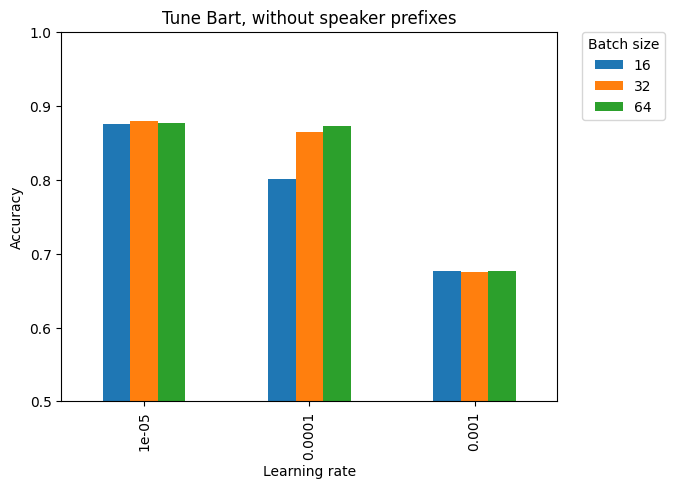

In [249]:
# df_mean.plot.bar(figsize=(10,3))
df_mean.plot.bar()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Batch size")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
# plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.xlabel("Learning rate")
plt.title(exp['comment'])# + "\nwith various model configurations and training parameters")

In [250]:
# df_time = df_grouped['time_total_s'].agg(['mean']).unstack().unstack()
df_time = df_grouped['time_total_s'].agg(['mean']).unstack()['mean']
df_time

config/batch_size,16,32,64
config/learning_rate,,,
0.00001,678.743218,720.292901,630.831672
0.00010,549.888993,649.055010,600.018667
0.00100,268.237531,413.387231,429.284796


Text(0.5, 1.0, 'Tune Bart, without speaker prefixes\nwith various model configurations and training parameters')

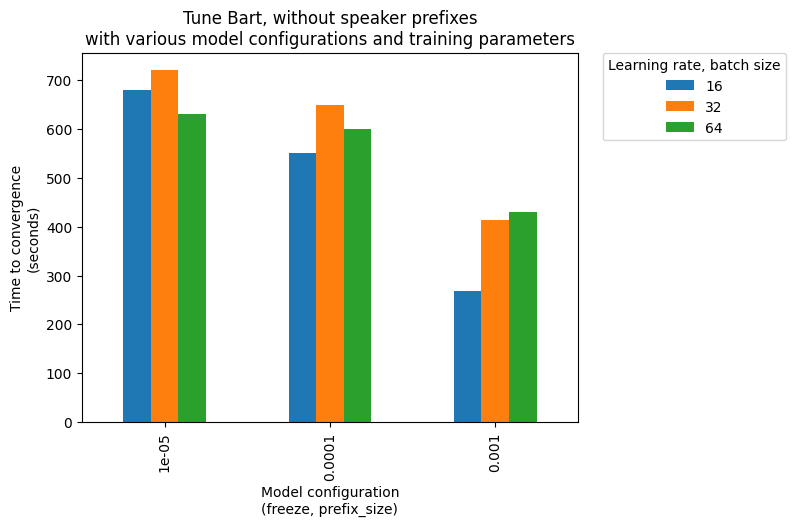

In [252]:
# df_time['mean'].plot.bar(figsize=(10,3))
df_time.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Learning rate, batch size")
plt.ylabel("Time to convergence\n(seconds)")
plt.xlabel("Model configuration\n(freeze, prefix_size)")
plt.title(exp['comment'] + "\nwith various model configurations and training parameters")

In [183]:
# Get the result with the maximum test set `mean_accuracy`
best_result = result_grid.get_best_result()
best_result.config

{'seed': 42,
 'prefix_aggr': 'concat',
 'learning_rate': 0.0001,
 'batch_size': 32,
 'prefix_size': 0,
 'freeze': 8}

<Axes: xlabel='training_iteration'>

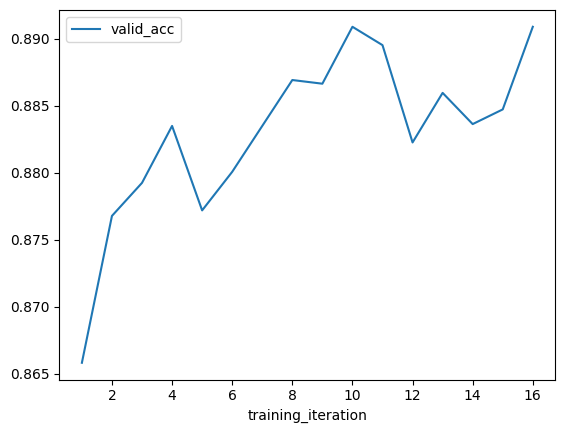

In [184]:
best_result.metrics_dataframe.plot("training_iteration", "valid_acc")

In [185]:
df.groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_size'])['valid_acc', 'time_total_s'].agg(['mean', 'std'])

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_5608/397826947.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_size'])['valid_acc', 'time_total_s'].agg(['mean', 'std'])


valid_acc  \
                                                                             mean   
config/batch_size config/learning_rate config/freeze config/prefix_size             
16                0.00001              8.0           0                   0.881273   
                                       12.0          0                   0.726099   
                                                     5                   0.713721   
                  0.00010              8.0           0                   0.885096   
                                       12.0          0                   0.855495   
                                                     5                   0.854533   
                  0.00100              8.0           0                   0.691703   
                                       12.0          0                   0.845948   
                                                     5                   0.847237   
32                0.00001              8.0           0                   0.884663   
                                       12.0          0                   0.699150   
                                                     5                   0.707861   
                  0.00010              8.0           0                   0.888706   
                                       12.0          0                   0.852419   
                                                     5                   0.860791   
                  0.00100              8.0           0                   0.675713   
                                       12.0          0                   0.854715   
                                                     5                   0.855096   
64                0.00001              8.0           0                   0.881340   
                                       12.0          0                   0.698063   
                                                     5                   0.699299   
                  0.00010              8.0           0                   0.889848   
                                       12.0          0                   0.851387   
                                                     5                   0.852151   
                  0.00100              8.0           0                   0.723517   
                                       12.0          0                   0.861340   
                                                     5                   0.859768   

                                                                                   \
                                                                              std   
config/batch_size config/learning_rate config/freeze config/prefix_size             
16                0.00001              8.0           0                   0.003859   
                                       12.0          0                   0.035966   
                                                     5                   0.051199   
                  0.00010              8.0           0                   0.000789   
                                       12.0          0                   0.003709   
                                                     5                   0.005765   
                  0.00100              8.0           0                   0.034892   
                                       12.0          0                   0.006508   
                                                     5                   0.004273   
32                0.00001              8.0           0                   0.000485   
                                       12.0          0                   0.026361   
                                                     5                   0.048871   
                  0.00010              8.0           0                   0.002342   
                                       12.0          0                   0.006228   
                                                     5                   0.0

In [187]:
df[df['config/prefix_size'] == 5].groupby(['config/batch_size', 'config/learning_rate', 'config/freeze', 'config/prefix_aggr'])['valid_acc'].max()

config/batch_size  config/learning_rate  config/freeze  config/prefix_aggr
16                 0.00001               12.0           avg                   0.676374
                                                        concat                0.799313
                                                        max                   0.700137
                   0.00010               12.0           avg                   0.851648
                                                        concat                0.862775
                                                        max                   0.857967
                   0.00100               12.0           avg                   0.853571
                                                        concat                0.846566
                                                        max                   0.849451
32                 0.00001               12.0           avg                   0.675713
                                                       

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   valid_acc                 162 non-null    float64
 1   time_this_iter_s          162 non-null    float64
 2   done                      162 non-null    bool   
 3   timesteps_total           19 non-null     float64
 4   episodes_total            19 non-null     float64
 5   training_iteration        162 non-null    int64  
 6   trial_id                  162 non-null    object 
 7   experiment_id             162 non-null    object 
 8   date                      162 non-null    object 
 9   timestamp                 162 non-null    int64  
 10  time_total_s              162 non-null    float64
 11  pid                       162 non-null    int64  
 12  hostname                  162 non-null    object 
 13  node_ip                   162 non-null    object 
 14  time_since